In [2]:
import pandas as pd
import numpy as np
import psycopg2

# Connect to the newyork database
conn = psycopg2.connect(
    dbname = 'newyork',
    user = '',
    password = '',
    host = 'localhost',
    port = '5432'
)

# Get the top 50 nodes by negative price occurence
query = f"SELECT node, COUNT(*) FROM realtime_lbmp WHERE price < 0 GROUP BY node ORDER BY COUNT(*) DESC LIMIT 21;"
df = pd.read_sql_query(query, conn)
best_nodes = list(df.node)

# There are 58'943'742 elements in the file, so roughly 80k points per node
query = f"SELECT * FROM realtime_lbmp WHERE node IN %s"
df = pd.read_sql_query(query, conn, params=(tuple(best_nodes),))[['time','node','price']]
df = df.sort_values(by='time')
conn.close()

df.head()

/var/folders/0x/l1m3sdhn7r59npk394yrpzk40000gn/T/ipykernel_655/2200599366.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/var/folders/0x/l1m3sdhn7r59npk394yrpzk40000gn/T/ipykernel_655/2200599366.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(tuple(best_nodes),))[['time','node','price']]


,time,node,price
0,2023-09-01 00:05:00,ALTONA_WT_PWR,22.86
20,2023-09-01 00:05:00,V_XM_10_SYNC_DSASP,23.00
19,2023-09-01 00:05:00,V_CMP_10_SYNC_DSASP,23.00
18,2023-09-01 00:05:00,PLATSBRG_115KV_PMLD1,23.00
17,2023-09-01 00:05:00,NORTH___COUNTRY_ESR,22.68


In [4]:
# Find the minimum length of prices
min_length = 1e9
for node in best_nodes:
    df_node = df[df.node==node]
    if len(df_node) < min_length:
        min_length = len(df_node)
print(f'The node with the least points has data for {min_length} time steps.')

# Set up as a dict and crop price lists at min_length
prices = {}
for node in best_nodes:
    prices[node] = list(df[df.node==node].price)[:min_length]

for key, value in prices.items():
    print(f'{key}: {value[:10]}...')

The node with the least points has data for 80226 time steps.
CLINTON_WT_PWR: [22.77, 21.43, 23.43, 23.4, 23.4, 23.94, 23.89, 23.24, 23.22, 21.45]...
CHATEAUG_WT_PWR: [22.77, 21.43, 23.43, 23.4, 23.4, 23.94, 23.89, 23.24, 23.22, 21.45]...
ELLENBURG_WT_PWR: [22.77, 21.43, 23.43, 23.4, 23.4, 23.94, 23.89, 23.24, 23.22, 21.45]...
JERICHO_RISE_WT_PWR: [22.68, 21.36, 23.36, 23.33, 23.33, 23.87, 23.82, 23.17, 23.15, 21.38]...
NORTH___COUNTRY_ESR: [22.68, 21.36, 23.36, 23.33, 23.33, 23.87, 23.82, 23.17, 23.15, 21.38]...
CHAT_HIGH_FALL_HYD: [22.75, 21.45, 23.43, 23.4, 23.43, 23.96, 23.89, 23.24, 23.24, 21.45]...
CHATEAUG_35_KV_LOAD: [22.75, 21.45, 23.43, 23.4, 23.43, 23.96, 23.89, 23.24, 23.24, 21.45]...
NEG NORTH_KES_CHATEGAY: [22.75, 21.45, 23.43, 23.4, 23.43, 23.96, 23.89, 23.24, 23.24, 21.45]...
KNTFSRNC_46_KV_46KV_LOAD: [23.02, 21.66, 23.66, 23.64, 23.66, 24.2, 24.15, 23.47, 23.47, 21.66]...
CLINTON___LFGE: [23.02, 21.66, 23.66, 23.64, 23.66, 24.2, 24.15, 23.47, 23.47, 21.66]...
NEG NORTH

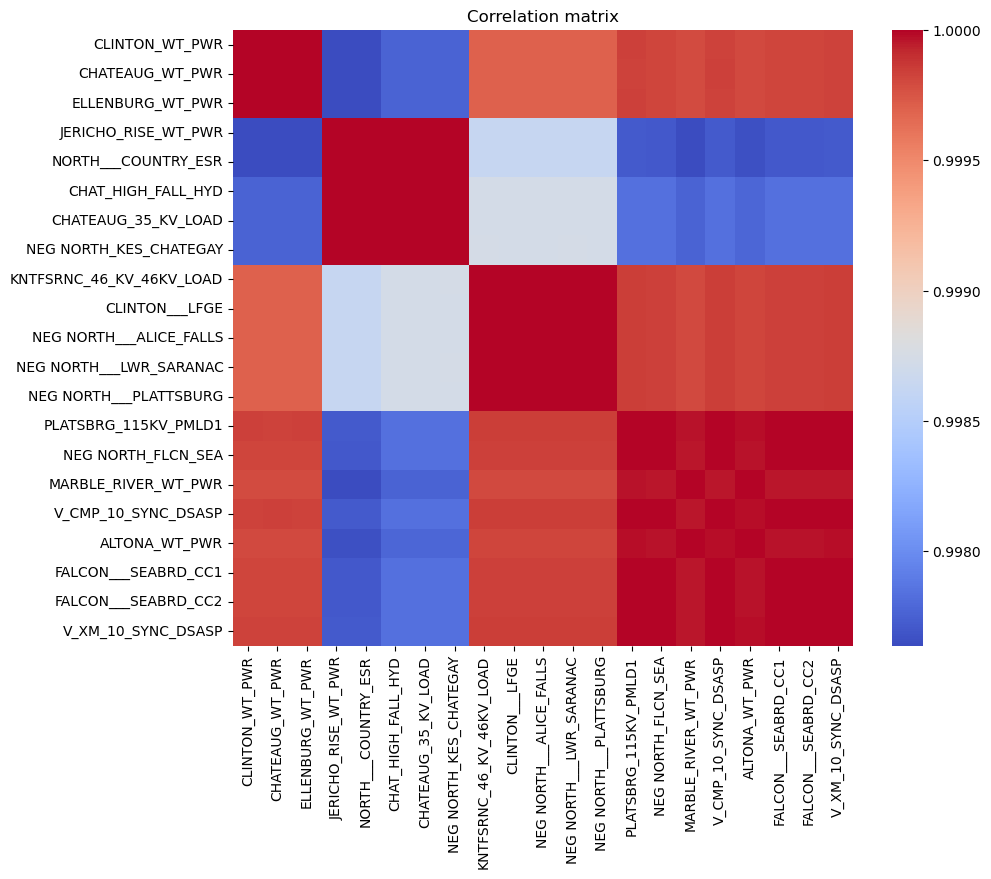

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = pd.DataFrame(prices).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

In [126]:
df = pd.read_csv('nodes_coord.csv',sep=';')
display(df)
df = df[['Name','Lat','Long']].dropna()

,Name,Lat,Long,Subzone,Note
0,CLINTON_WT_PWR,44.890926,-73.985407,NYPA NORTH,NaN
1,CHATEAUG_WT_PWR,44.890926,-73.985407,NYPA NORTH,NaN
2,ELLENBURG_WT_PWR,44.890926,-73.985407,NYPA NORTH,NaN
3,JERICHO_RISE_WT_PWR,44.889084,-74.118278,NYPA NORTH,NaN
4,NORTH___COUNTRY_ESR,NaN,NaN,NYPA NORTH,Coordinates not given
5,CHAT_HIGH_FALL_HYD,44.893450,-74.073266,NYSEG NORTH,NaN
6,CHATEAUG_35_KV_LOAD,NaN,NaN,NYNO,Transmission node
7,NEG NORTH_KES_CHATEGAY,44.893450,-74.073266,NYSEG NORTH,NaN
8,KNTFSRNC_46_KV_46KV_LOAD,NaN,NaN,NYNO,Transmission node
9,CLINTON___LFGE,44.703599,-73.595810,NYSEG NORTH,NaN


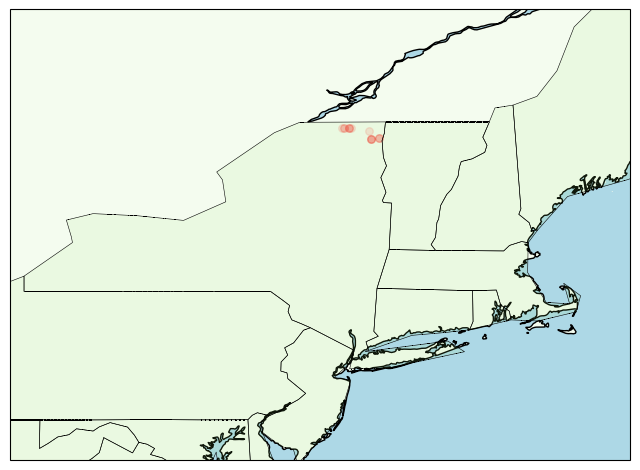

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

data = {
    'Name': list(df.Name),
    'Lat': list(df.Lat),
    'Long': list(df.Long)}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(df['Long'], df['Lat'], color='red', alpha=0.1, s=30, transform=ccrs.PlateCarree())

# Add names to points
#for i, txt in enumerate(df['Name']):
    #ax.text(df['Long'][i], df['Lat'][i], txt, fontsize=5, transform=ccrs.PlateCarree())

ax.set_extent([-75, -73, 44, 45.3])
ax.set_extent([-80, -69, 39, 47])

shpfilename = '110m_cultural/ne_110m_admin_1_states_provinces_lakes.shp'
reader = shapereader.Reader(shpfilename)
states = reader.records()

for state in states:
    if state.attributes['admin'] == 'United States of America':
        ax.add_geometries([state.geometry], ccrs.PlateCarree(), facecolor=(0.6, 0.9, 0.4, 0.1), edgecolor='black', linewidth=0.4)

ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor=(0.6, 0.9, 0.4, 0.1))

plt.show()
